In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from utils import db_connect
engine = db_connect()
main_econ_df = pd.read_sql('SELECT * FROM main_econ_view', con=engine)

Connection successful


In [2]:
main_econ_df.head(1)

,NCESSCH,SURVYEAR,LEAID,LEA_NAME,SCH_NAME,CHARTER_TEXT,MAGNET_TEXT,TOTFRL,FRELCH,REDLCH,...,BPL_ALL_FAM,TH_50_75K,TH_75_100K,TH_25_35K,TH_150_200K,TH_35_50K,TH_WITH_SNAP,BPL_ALL,TH_200K_AND_ABOVE,econ_rolling_year_period
0,411129001772,2018,4111290,Sherwood SD 88J,Edy Ridge Elementary School,No,0,85,72,13,...,3.3,11.5,10.6,2.9,13.8,8.0,3.9,4.8,24.5,2018-2022


In [3]:
main_econ_df['LEAID'] = main_econ_df['LEAID'].astype(int)

In [4]:
# PREPROCESSING
# Ethnicity proportions
for col in ['AM','AS','BL','HP','HI','TR','WH']:
    main_econ_df[f'prop_{col}'] = main_econ_df[col] / main_econ_df['TOTAL']

# Grade-level ratios
main_econ_df['upper_grades_ratio'] = main_econ_df[['G09','G10','G11','G12','G13']].sum(axis=1) / main_econ_df['TOTAL']
main_econ_df['lower_grades_ratio'] = main_econ_df[['PK','KG','G01','G02','G03','G04','G05']].sum(axis=1) / main_econ_df['TOTAL']
main_econ_df['middle_grades_ratio'] = main_econ_df[['G06','G07','G08']].sum(axis=1) / main_econ_df['TOTAL']

# Free/reduced lunch ratios
main_econ_df['frl_ratio'] = main_econ_df['FRELCH'] / main_econ_df['TOTFRL']
main_econ_df['redl_ratio'] = main_econ_df['REDLCH'] / main_econ_df['TOTFRL']

cols_to_drop = ['AM','AS','BL','HP','HI','TR','WH', 'G06','G07','G08','G09','G10','G11','G12','G13', 'PK','KG','G01','G02','G03','G04','G05', 'TOTFRL']

main_econ_df.drop(columns=cols_to_drop, inplace=True)

main_econ_df.loc[main_econ_df['CHARTER_TEXT'] == 0, 'CHARTER_TEXT'] = 'Missing'
main_econ_df.loc[main_econ_df['MAGNET_TEXT'] == 0, 'MAGNET_TEXT'] = 'Missing'

In [5]:
main_econ_df.drop(columns=['NCESSCH', 'SURVYEAR', 'LEA_NAME', 
                      'SCH_NAME', 'FRELCH', 'REDLCH', 'FTE', 'STUTERATIO'], inplace=True)

In [6]:
cat_cols=main_econ_df.select_dtypes(include=['object','category']).columns
cat_cols

C:\Users\caleb\AppData\Local\Temp\ipykernel_11948\4279560497.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols=main_econ_df.select_dtypes(include=['object','category']).columns


Index(['CHARTER_TEXT', 'MAGNET_TEXT', 'locale_category', 'TITLEI_GROUPED',
       'econ_rolling_year_period'],
      dtype='str')

In [7]:
cat_cols

Index(['CHARTER_TEXT', 'MAGNET_TEXT', 'locale_category', 'TITLEI_GROUPED',
       'econ_rolling_year_period'],
      dtype='str')

In [8]:
main_econ_df.drop(columns=['econ_rolling_year_period'], inplace=True)

In [9]:
main_econ_df = pd.get_dummies(
    main_econ_df,
    columns=main_econ_df.select_dtypes(include=['object','category']).columns,
    drop_first=True
)

C:\Users\caleb\AppData\Local\Temp\ipykernel_11948\869359652.py:3: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  columns=main_econ_df.select_dtypes(include=['object','category']).columns,


In [10]:
main_econ_df.columns

Index(['LEAID', 'UG', 'TOTAL', 'LATCOD', 'LONCOD', 'high_strain', 'TH_10_15K',
       'TH_15_25K', 'TH_WITH_CASH_ASSIST', 'TH_100_150K', 'TH_LT_10K',
       'BPL_ALL_FAM', 'TH_50_75K', 'TH_75_100K', 'TH_25_35K', 'TH_150_200K',
       'TH_35_50K', 'TH_WITH_SNAP', 'BPL_ALL', 'TH_200K_AND_ABOVE', 'prop_AM',
       'prop_AS', 'prop_BL', 'prop_HP', 'prop_HI', 'prop_TR', 'prop_WH',
       'upper_grades_ratio', 'lower_grades_ratio', 'middle_grades_ratio',
       'frl_ratio', 'redl_ratio', 'CHARTER_TEXT_No', 'CHARTER_TEXT_Yes',
       'MAGNET_TEXT_No', 'MAGNET_TEXT_Yes', 'locale_category_Rural',
       'locale_category_Suburb', 'locale_category_Town',
       'TITLEI_GROUPED_Error', 'TITLEI_GROUPED_Not_Eligible',
       'TITLEI_GROUPED_Schoolwide', 'TITLEI_GROUPED_Targeted',
       'TITLEI_GROUPED_Unknown'],
      dtype='str')

In [ ]:
# take another look at the TITLEI_GROUPED being "Error"

In [11]:
main_econ_df.loc[main_econ_df['frl_ratio'].isna(), 'frl_ratio'] = 0
main_econ_df.loc[main_econ_df['redl_ratio'].isna(), 'redl_ratio'] = 0

In [19]:
main_econ_df = main_econ_df.replace("NaN", 0)

In [20]:
main_econ_df = main_econ_df.fillna(0)

In [21]:
X = main_econ_df.drop(columns=["high_strain"])
y = main_econ_df["high_strain"]

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [23]:
main_econ_df[main_econ_df.isna().any(axis=1)]

,LEAID,UG,TOTAL,LATCOD,LONCOD,high_strain,TH_10_15K,TH_15_25K,TH_WITH_CASH_ASSIST,TH_100_150K,...,MAGNET_TEXT_No,MAGNET_TEXT_Yes,locale_category_Rural,locale_category_Suburb,locale_category_Town,TITLEI_GROUPED_Error,TITLEI_GROUPED_Not_Eligible,TITLEI_GROUPED_Schoolwide,TITLEI_GROUPED_Targeted,TITLEI_GROUPED_Unknown


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs", "liblinear"]
}

grid = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=500),
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(X_train, y_train)

c:\Users\caleb\4Geeks_Capstone\4Geeks_Capstone_Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\caleb\4Geeks_Capstone\4Geeks_Capstone_Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LogisticRegre... max_iter=500)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.01, 0.1, ...], 'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score i

In [25]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

cv_model = grid.best_estimator_
print(grid.best_params_)

cv_y_pred = cv_model.predict(X_test)
cv_y_prob = cv_model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, cv_y_pred))
print("ROC AUC:", roc_auc_score(y_test, cv_y_prob))
print(classification_report(y_test, cv_y_pred))

{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.7309640408563034
ROC AUC: 0.7324797959009923
              precision    recall  f1-score   support

           0       0.95      0.74      0.84     32733
           1       0.17      0.59      0.27      3002

    accuracy                           0.73     35735
   macro avg       0.56      0.67      0.55     35735
weighted avg       0.89      0.73      0.79     35735



# After introducing 5 year rolling period financial data, we had the following changes with Logistic Regression:

 - ROC AUC - slight improvement in ranking ability
 - Recall - slight drop
 - Precision - slight improvement
 - F1 slight improvement

This financial data seemed to add some signal, but not a massive amount

I've reached the following insights:
Either -
1. Financial data overlaps heavily with existing predictors
2. Student/Teacher strain is not strongly driven by these variables
3. Logistic Regression can't capture nonlinear financial interactions

Is this problem fundamentally linear?


In [26]:
# I think the next step here is to explore other modeling options.
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

In [27]:
# handle class imbalance
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight = neg / pos
print(scale_pos_weight)

10.9027396119577


In [28]:
# baseline xgb model
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:,1]

print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

c:\Users\caleb\4Geeks_Capstone\4Geeks_Capstone_Project\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:25:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ROC AUC: 0.9270211370201716
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     32733
           1       0.37      0.84      0.51      3002

    accuracy                           0.87     35735
   macro avg       0.68      0.86      0.72     35735
weighted avg       0.93      0.87      0.89     35735



In [29]:
# very distinct change here in metrics, let's see if we can tune this
param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5]
}

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

search = RandomizedSearchCV(
    xgb,
    param_distributions=param_grid,
    n_iter=25,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1
)

search.fit(X_train, y_train)

best_model = search.best_estimator_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [30]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print("Best Params:", search.best_params_)
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Best Params: {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
ROC AUC: 0.9357479437175185
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     32733
           1       0.49      0.77      0.60      3002

    accuracy                           0.91     35735
   macro avg       0.74      0.85      0.78     35735
weighted avg       0.94      0.91      0.92     35735



# Significant improvement, let's double check overfitting


In [31]:
train_proba = best_model.predict_proba(X_train)[:,1]
print("Train AUC:", roc_auc_score(y_train, train_proba))
test_proba = best_model.predict_proba(X_test)[:,1]
print("Test AUC:", roc_auc_score(y_test, test_proba))

Train AUC: 0.9969227777951901
Test AUC: 0.9357479437175185


In [32]:
# model is showing some overfitting, going to try to reduce the learning rate, but up trees, 
# may try to regularize with penalties

param_grid = {
    "n_estimators": [700, 800, 1000],
    "max_depth": [4, 5],
    "learning_rate": [0.03, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5]
}

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

search = RandomizedSearchCV(
    xgb,
    param_distributions=param_grid,
    n_iter=25,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1
)

search.fit(X_train, y_train)

best_model = search.best_estimator_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [33]:
train_proba = best_model.predict_proba(X_train)[:,1]
print("Train AUC:", roc_auc_score(y_train, train_proba))
test_proba = best_model.predict_proba(X_test)[:,1]
print("Test AUC:", roc_auc_score(y_test, test_proba))

Train AUC: 0.9787822403037053
Test AUC: 0.9317849139891525


In [34]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print("Best Params:", search.best_params_)
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Best Params: {'subsample': 0.8, 'n_estimators': 700, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
ROC AUC: 0.9317849139891525
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     32733
           1       0.39      0.84      0.54      3002

    accuracy                           0.88     35735
   macro avg       0.69      0.86      0.73     35735
weighted avg       0.93      0.88      0.90     35735



In [ ]:
# Since we have LEAID district info, removing geographical info
X_train.drop(columns=(['LATCOD', 'LONCOD']), inplace=True)
X_test.drop(columns=(['LATCOD', 'LONCOD']), inplace=True)
X_train.drop(columns='TOTAL', inplace=True)
X_test.drop(columns='TOTAL', inplace=True)
# what if we removed geography altogether?
X_train.drop(columns='LEAID', inplace=True)
X_test.drop(columns='LEAID', inplace=True)

In [ ]:
# using a more generalized learning rate to try and generalize model from training data, 
# letting estimators go, but adding stopping limit, forcing a max depth, and adding in penalties
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.06,
    n_estimators=1300,
    max_depth=5,
    subsample=0.70,
    colsample_bytree=0.85,
    min_child_weight=5,
    reg_alpha=1,
    reg_lambda=2,
    early_stopping_rounds=50,
    random_state=42
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.85
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",50
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fr

In [152]:
train_proba = model.predict_proba(X_train)[:,1]
print("Train AUC:", roc_auc_score(y_train, train_proba))
test_proba = model.predict_proba(X_test)[:,1]
print("Test AUC:", roc_auc_score(y_test, test_proba))

Train AUC: 0.970487679705644
Test AUC: 0.9128252475314933


In [153]:
# excellent, so we ended up making the model more generalized, and upped the test AUC
# now let's see how this does
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

ROC AUC: 0.9128252475314933
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     32733
           1       0.36      0.80      0.50      3002

    accuracy                           0.87     35735
   macro avg       0.67      0.84      0.71     35735
weighted avg       0.93      0.87      0.89     35735



# Bias-variance control

 - Prior to regularization:
  -- Train AUC: 0.996
  -- Test AUC: 0.936
 - Post regularization:
  -- Train AUC: 0.979
  -- Test AUC: 0.933

- After removing geographic and total information (to really drill down into socio-economic indicators)
  -- Train AUC: 0.970
  -- Test AUC: 0.912 

Reduced variance, kept test performance high, resulting in a more stable model

Based on above:

- Caught 80% of strained schools on a ~10% minority class
- When it's flagged, we're right about 36% of the time

# Visualizing the ROC AUC

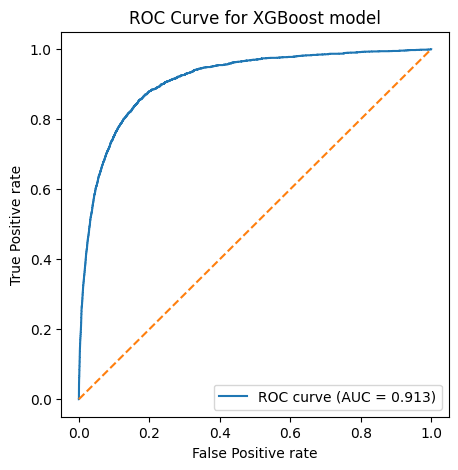

In [161]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC Curve for XGBoost model')
plt.legend()
plt.show()

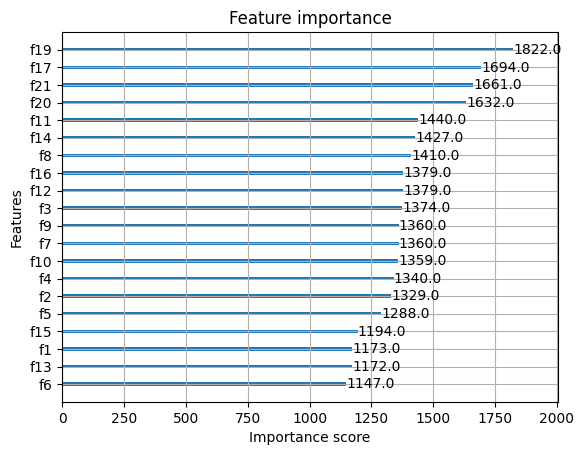

In [162]:
from xgboost import plot_importance

# Plot global feature importance
plot_importance(model, importance_type='weight', max_num_features=20)
plt.show()

In [ ]:
# map these features back

In [163]:
# using total_gain for global importance 
booster = model.get_booster()
score = booster.get_score(importance_type='total_gain')

mapped_score = {
    X_train.columns[int(k[1:])]: v
    for k, v in score.items()
}

print(mapped_score)

{'UG': 47257.31640625, 'TH_10_15K': 52615.4375, 'TH_15_25K': 60075.82421875, 'TH_WITH_CASH_ASSIST': 61812.32421875, 'TH_100_150K': 58761.8515625, 'TH_LT_10K': 54657.56640625, 'BPL_ALL_FAM': 54671.66015625, 'TH_50_75K': 57736.8203125, 'TH_75_100K': 68094.5234375, 'TH_25_35K': 57065.68359375, 'TH_150_200K': 57293.4765625, 'TH_35_50K': 62260.9609375, 'TH_WITH_SNAP': 71061.21875, 'BPL_ALL': 51754.0, 'TH_200K_AND_ABOVE': 85129.125, 'prop_AM': 40857.85546875, 'prop_AS': 63130.29296875, 'prop_BL': 74121.0390625, 'prop_HP': 39414.06640625, 'prop_HI': 69803.7421875, 'prop_TR': 46214.890625, 'prop_WH': 64745.1015625, 'upper_grades_ratio': 62120.3515625, 'lower_grades_ratio': 98727.6015625, 'middle_grades_ratio': 41246.1171875, 'frl_ratio': 38412.85546875, 'redl_ratio': 33761.140625, 'CHARTER_TEXT_No': 5510.2373046875, 'CHARTER_TEXT_Yes': 3986.317138671875, 'MAGNET_TEXT_No': 16280.9638671875, 'MAGNET_TEXT_Yes': 2969.4912109375, 'locale_category_Rural': 13925.76953125, 'locale_category_Suburb': 12

In [164]:
# create a df so we can take a look
importance_df = (
    pd.DataFrame.from_dict(mapped_score, orient='index', columns=['total_gain'])
      .sort_values('total_gain', ascending=False)
      .reset_index()
      .rename(columns={'index': 'feature'})
)

importance_df['pct_of_total'] = (
    importance_df['total_gain'] / importance_df['total_gain'].sum()
)

importance_df.head(15)

,feature,total_gain,pct_of_total
0,lower_grades_ratio,98727.601562,0.059720
1,TH_200K_AND_ABOVE,85129.125000,0.051495
2,prop_BL,74121.039062,0.044836
3,TH_WITH_SNAP,71061.218750,0.042985
4,prop_HI,69803.742188,0.042224
5,TH_75_100K,68094.523438,0.041190
6,prop_WH,64745.101562,0.039164
7,prop_AS,63130.292969,0.038188
8,TH_35_50K,62260.960938,0.037662
9,upper_grades_ratio,62120.351562,0.037577


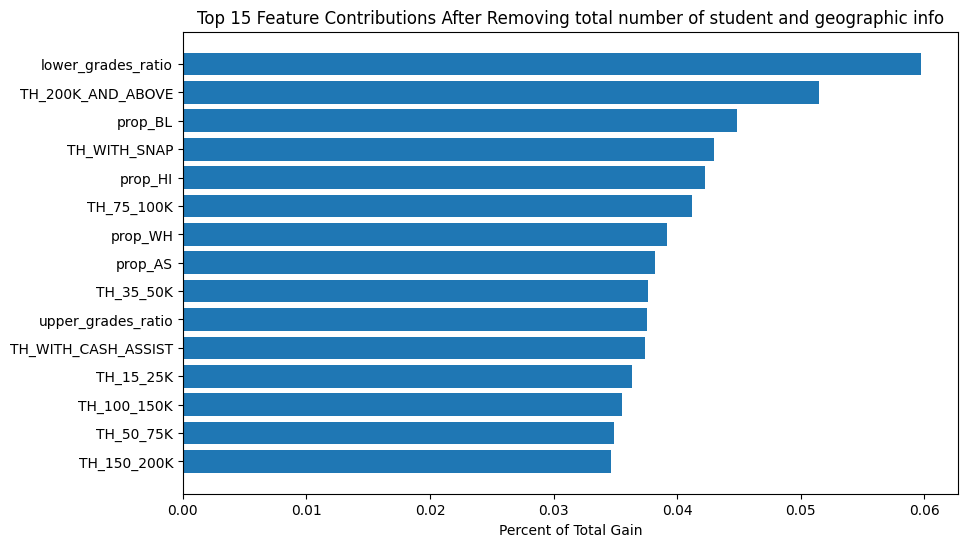

In [165]:
top_n = 15
plt.figure(figsize=(10,6))
plt.barh(
    importance_df['feature'][:top_n][::-1],
    importance_df['pct_of_total'][:top_n][::-1]
)
plt.xlabel("Percent of Total Gain")
plt.title("Top 15 Feature Contributions After Removing total number of student and geographic info")
plt.show()

In [ ]:
# bagging vs boosting ensemble methods picking up on feature importance.